# Data analysis for Chapter "Global Optima and Fixed Points"

This notebook can be used to reproduce the data analysis of the introduction and Chapter "Global Optima and Fixed Points" of the technical report ["Assessing a Formal Model of Reflective Equilibrium"](https://re-models.github.io/re-technical-report/). 

## How to run this notebook

There are several possibilities to execute this notebook. You can, for instance,

1. execute this notebook on Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/re-models/re-technical-report/blob/main/notebooks/data_analysis_chapter-go-and-fp.ipynb), or
2. execute this notebook locally in, for instance, [JupyterLab](https://jupyter.org/) by cloning the Github repository of the report (for details, see <https://github.com/re-models/re-technical-report>).

Note, however, that Colab is not suited to analyse the full data set that is used in the report. Instead, you can only use the subdata set `TINY` (see <https://github.com/re-models/re-technical-report> for details).

## Installing and importing libraries

In [1]:
!pip install re-technical-report

In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path
from ast import literal_eval
from statistics import mean

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

from re_technical_report import *

In [2]:
# Directories that are use to save generated tables and figures.
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

# Are we on Colab?
on_colab = 'google.colab' in str(get_ipython())
# Configuring sns styles
set_errorbar_plot_style()
set_heatmap_plot_style()



## Loading data

In [3]:
usecols = ['model_name', 'ds', 'init_coms', 'n_sentence_pool', 'error_code',
           'weight_account', 'weight_systematicity', 
           'go_fixed_point', 'global_optima', 
           'fp_global_optimum', 'n_branches', 'n_fixed_points', 'n_global_optima',
           'fixed_point_is_global_optimum']
# data_name: one of 'TINY', 'MINI', 'FULL'
re_data = re_data_by_name(data_name="FULL", 
                          usecols=usecols,
                          data_dir=path.join(Path(getcwd()).parent.absolute(), "data"),
                          filter_erroneous_runs=False)

In [4]:
display(re_data.columns)

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'error_code', 'n_branches',
       'n_fixed_points', 'fixed_point_is_global_optimum', 'global_optima',
       'n_global_optima', 'go_fixed_point', 'fp_global_optimum',
       'model_short_name'],
      dtype='object')

## Data preparation

In [34]:
##### Adding some further cols
# Mean number of premises in tau
re_data['mean_n_premises'] = re_data.apply(lambda x: mean([len(arg)-1 for arg in literal_eval(x['ds'])]), axis=1)
# Adding bins for mean number of premises 
# Bins [1,1.25], ]1.25,1.5], ]1.5,1.75], ]1.75,2]
bins = {"1-1.25": (1,1.25),
        "1.25 - 1.5":(1.25,1.5),
        "1.5 - 1.75":(1.5,1.75),
        "1.75 - 2":(1.75,2)}

def get_bin_name(mean_n_premises):
    for key in bins.keys():
        min, max = bins[key]
        if mean_n_premises >=min and mean_n_premises<=max:
            return key

re_data['mean_n_premises_bin'] =  re_data.apply(lambda x: get_bin_name(x['mean_n_premises']) , axis=1)

In [67]:
# Do we calculate errors bars by bootstrapping?
bootstrap = True
n_resamples = 400
# We need different views on the data.

#### 1. Result perspective on gos among fps 
# Idea: We collapse rows belonging to one simulation setup to one row and explode in column 'fp_global_optimum'
# collapse
cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'] 
data_collapsed = re_data.drop_duplicates(cols_group_branches)
# explode
data_collapsed_fp_exploded = data_collapsed.explode('fp_global_optimum')

#### 2. Reachability of gos (share of gos that are reachable via RE processes)
# Idea: We collapse row of one simulation setup to one row and explode in column 'go_fixed_point'
# explode
data_collapsed_go_exploded = data_collapsed.explode('go_fixed_point')

## Model Overview

### Table

In [68]:
### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df1 = rel_share_of_property(re_data, 
                                    property_col='fp_global_optimum',
                                    collapse_branches=True,
                                    col_rename=col_rename, 
                                    bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df1)

### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df2 = rel_share_of_property(re_data, 
                                    property_col='go_fixed_point',
                                    collapse_branches=True,
                                    col_rename=col_rename, 
                                    bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df2)

### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df3 = rel_share_of_property(re_data, 
                                   property_col= 'fixed_point_is_global_optimum',
                                   collapse_branches=False,
                                   col_rename=col_rename, 
                                   bootstrap=bootstrap, n_resamples=n_resamples)


result_df_result_perspective = pd.concat([result_df1, result_df2, result_df3], axis=1)
display(result_df_result_perspective)

# Changing col names for readability
cols_for_tables = {'model_name':'Model',
                   'rel_fpgo_go': 'GO reachability',
                   'rel_fpgo_fp_rp': 'GO efficiency (result perspective)',
                   'rel_fpgo_fp_pp': 'GO efficiency (process perspective)',
                  }
#display(result_df.rename(columns=cols_for_tables))
# Exporting relevant cols
result_df_result_perspective = result_df_result_perspective.reset_index()
result_df_result_perspective[['model_name','rel_fpgo_fp_rp','rel_fpgo_fp_pp','rel_fpgo_go']].rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, 'table_go_fp.csv'), index=False)


,,rel_fpgo_fp_rp,std_fpgo_fp_rp,n_fpgo_rp,n_fixed_points,rel_fpgo_go,std_fpgo_go,n_global_optima,rel_fpgo_fp_pp,std_fpgo_fp_pp,n_fpgo_pp,n_branches
model_short_name,model_name,,,,,,,,,,,
LGRE,LinearGlobalRE,0.729682,0.000758,228233,312810,0.312697,0.000521,729780,0.729755,0.000815,228425,313029
LLRE,LinearLocalRE,0.441793,0.001031,101570,229903,0.139165,0.000395,729780,0.539350,0.000433,703739,1304858
QGRE,QuadraticGlobalRE,0.763378,0.000620,349751,458183,0.482438,0.000550,724950,0.751722,0.000592,397368,528652
QLRE,QuadraticLocalRE,0.329466,0.000608,194122,589157,0.267759,0.000521,724950,0.345576,0.000336,688657,1992773


### Venn Diagramms (result perspective)

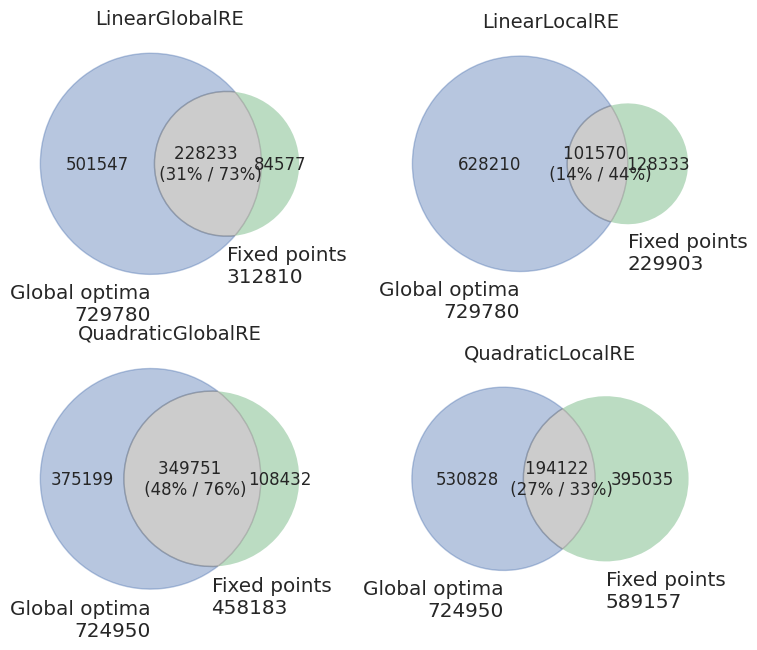

In [69]:
plot_venn(result_df_result_perspective, col_setA = "n_global_optima", col_setB = "n_fixed_points", 
          col_cut = "n_fpgo_rp", label_setA="Global optima", label_setB="Fixed points",
          output_dir=figures_output_dir, file_name='go-fp-venn')


## GO-Efficiency: GO among FP (result perspective)

### Dependence on sentence pool

In [70]:
bootstrap = True

### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df = rel_share_of_property(re_data, 
                                  property_col='fp_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  collapse_branches=True,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df.reset_index())

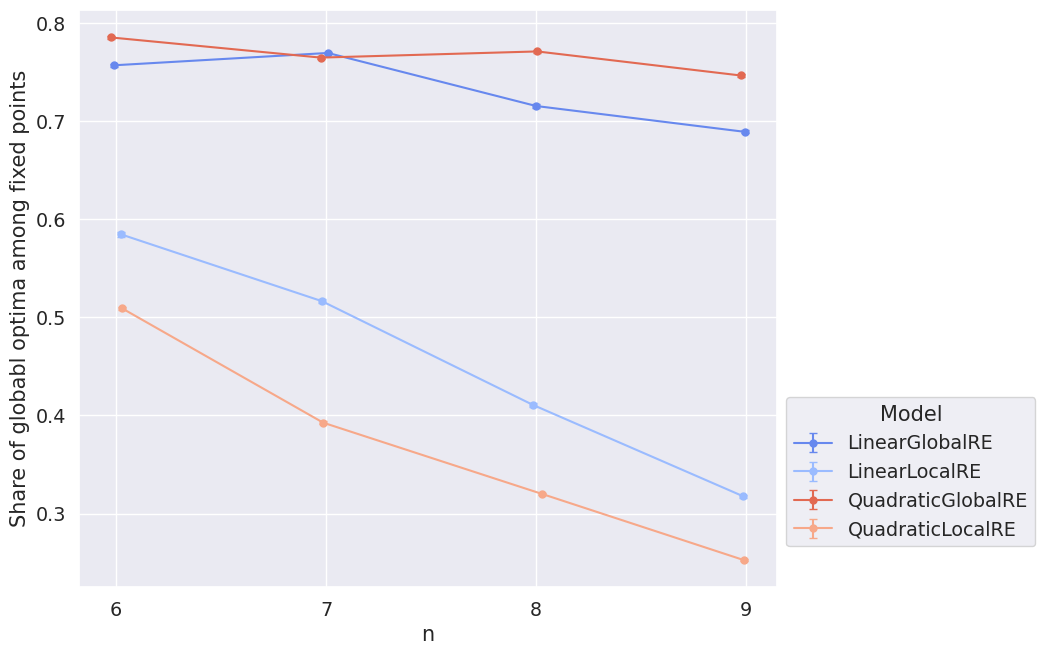

In [71]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_rp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_std = 'std_fpgo_fp_rp',
                         file_name='rel-fpgo-fp-by-n-rp', output_dir=figures_output_dir)

### Dependence on mean number of premises

In [72]:
### Calculating global optima among fixed points (Result perspective)
col_rename = {'mean':'rel_fpgo_fp_rp', 'std': 'std_fpgo_fp_rp', 'size':'n_fixed_points', 'sum':'n_fpgo_rp'}

result_df = rel_share_of_property(re_data, 
                                  property_col='fp_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  collapse_branches=True,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)
#display(result_df.reset_index())

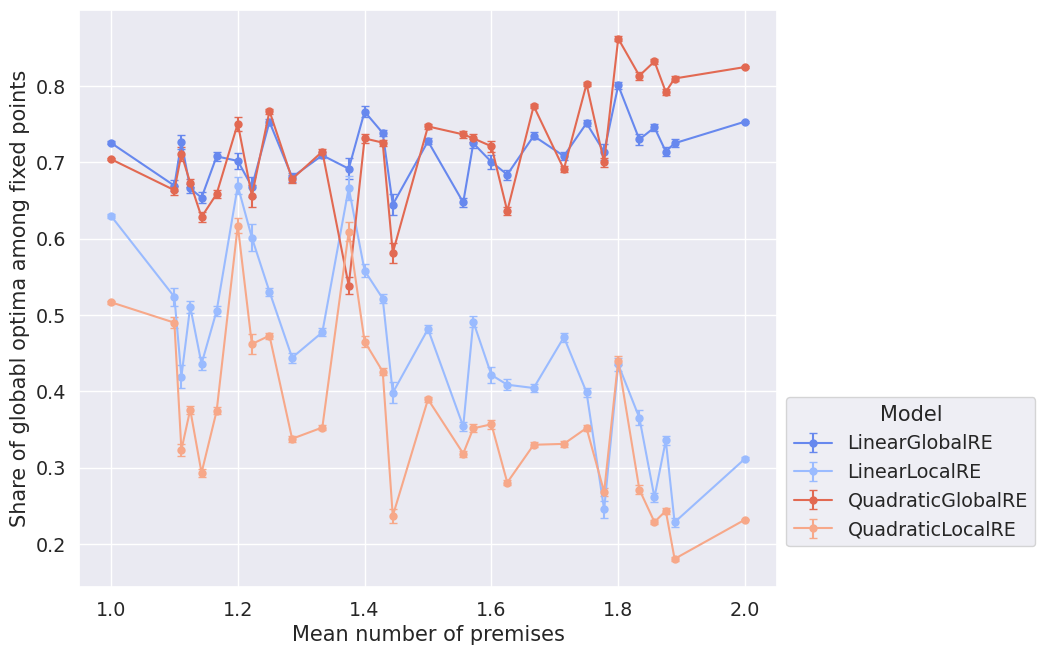

In [73]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_rp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_x = 'mean_n_premises', xlabel = 'Mean number of premises', xticks=None,
                         var_std = 'std_fpgo_fp_rp',
                         jitter=False,
                         file_name='rel-fpgo-fp-by-np-rp', output_dir=figures_output_dir)

### Dependence on $\alpha$-weights

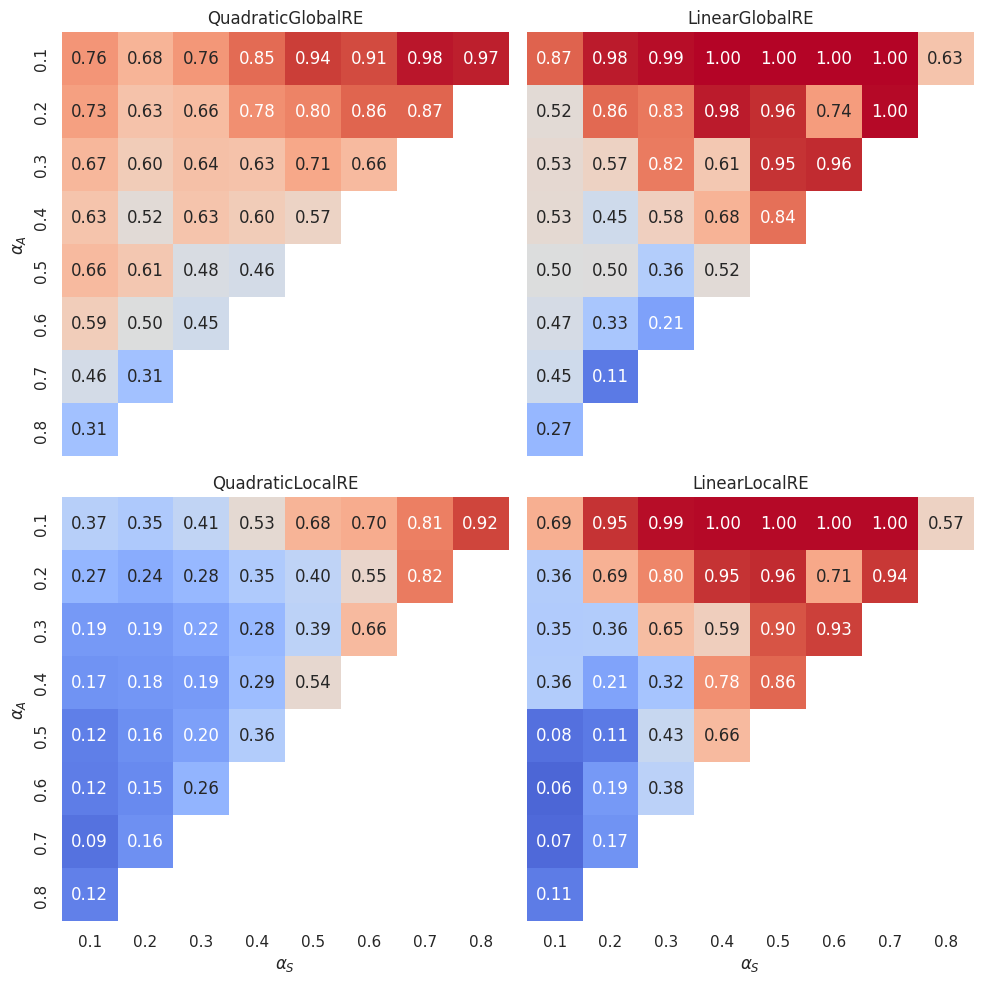

In [74]:
# Without bootstrapping
heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                     values ='fp_global_optimum', 
                     #title = 'Share of global optima among fixed points', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-fp-rp', output_dir=figures_output_dir,
                     bootstrap=False)

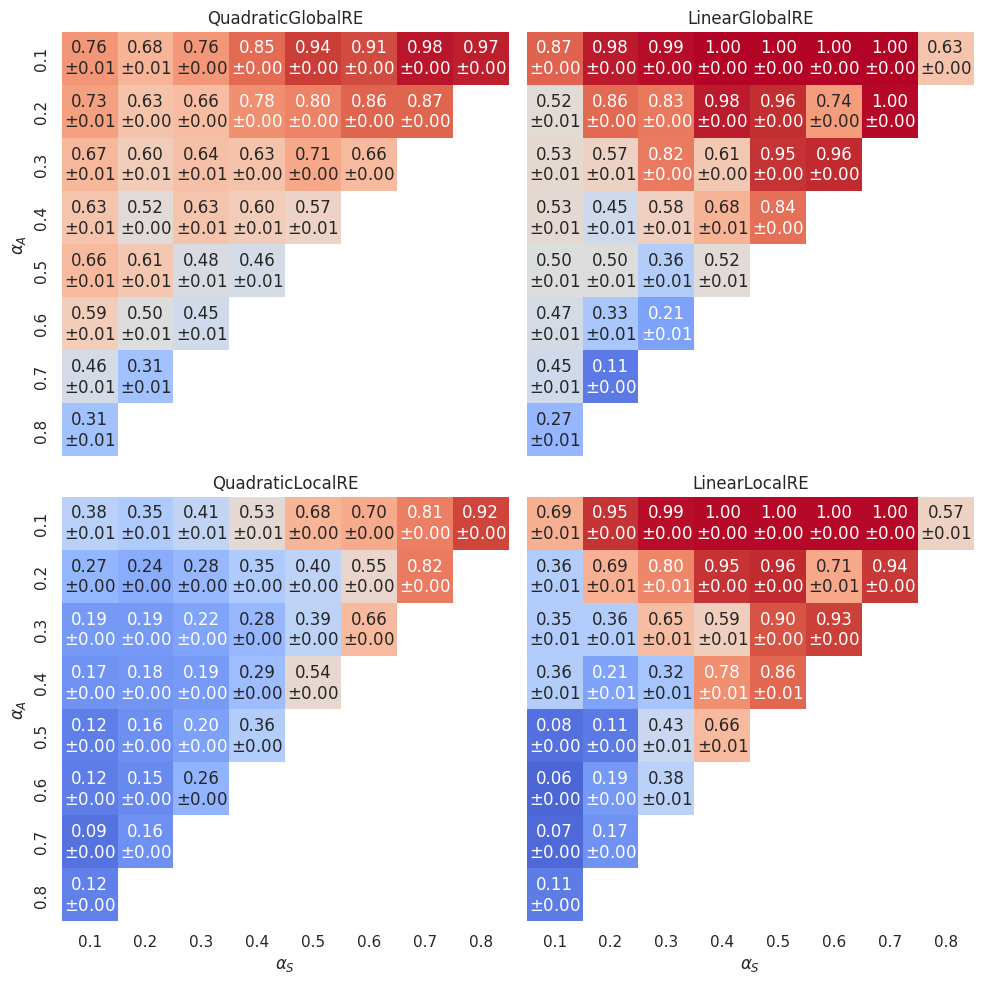

In [75]:
# With bootstrapping
heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                     values = 'fp_global_optimum', 
                     #title = 'Share of global optima among fixed points (result perspective)', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = True, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-fp-rp-std-bootstrap', output_dir=figures_output_dir,
                     bootstrap=True)
    

#### Local vs. Global (go among fp)

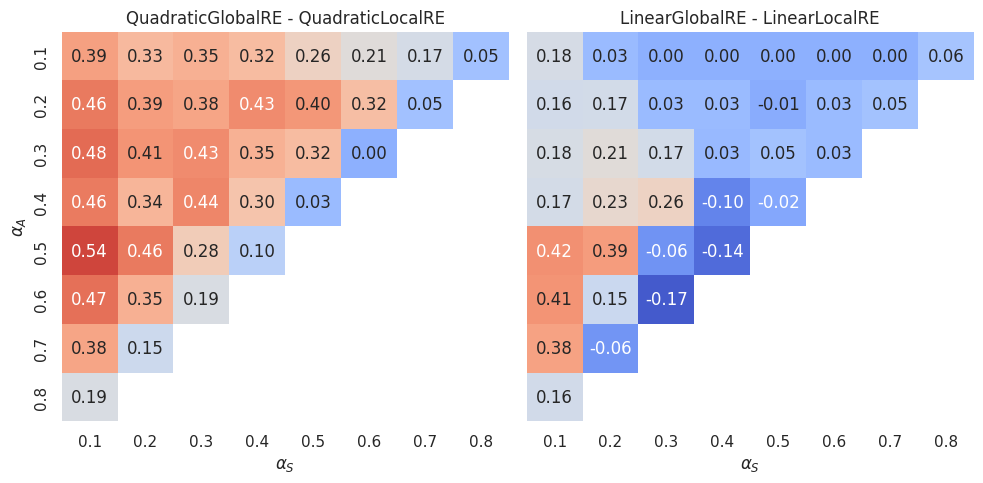

In [76]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                          values = 'fp_global_optimum',
                          #title = 'Share of global optima among fixed points (result perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-fp-rp', output_dir=figures_output_dir,
                          bootstrap=False)


### Dependence on $\alpha$-weights and mean number of premises

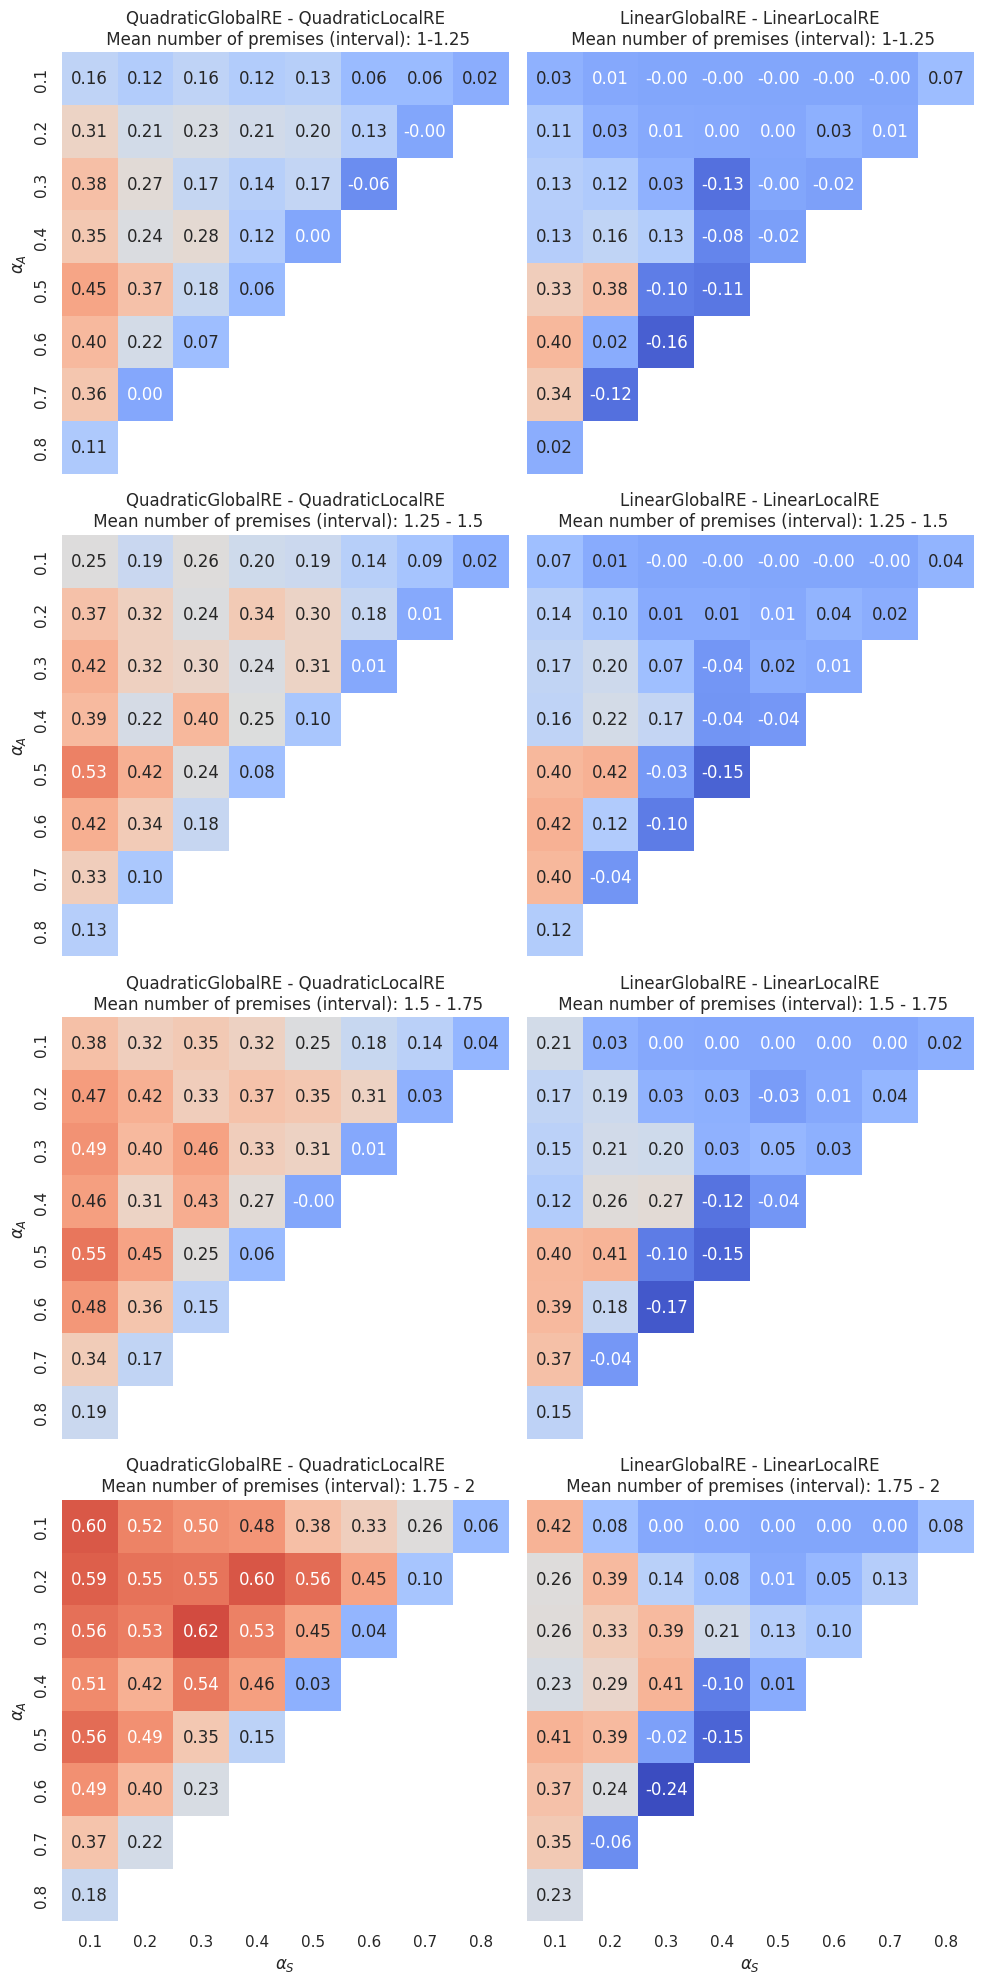

In [77]:
diff_heat_maps_by_weights(re_data = data_collapsed_fp_exploded, 
                          values = 'fp_global_optimum',
                          row='mean_n_premises_bin',
                          row_title='Mean number of premises (interval)',
                          #title = 'Share of global optima among fixed points (result perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.7,
                          file_name='diff-hm-rel-fpgo-fp-by-n-premises-rp', output_dir=figures_output_dir,
                          bootstrap=False)


## GO-Efficiency: GO among FP (process perspective)

### Dependence on sentence pool

In [9]:
### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df = rel_share_of_property(re_data, 
                                  property_col= 'fixed_point_is_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  collapse_branches=False,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)

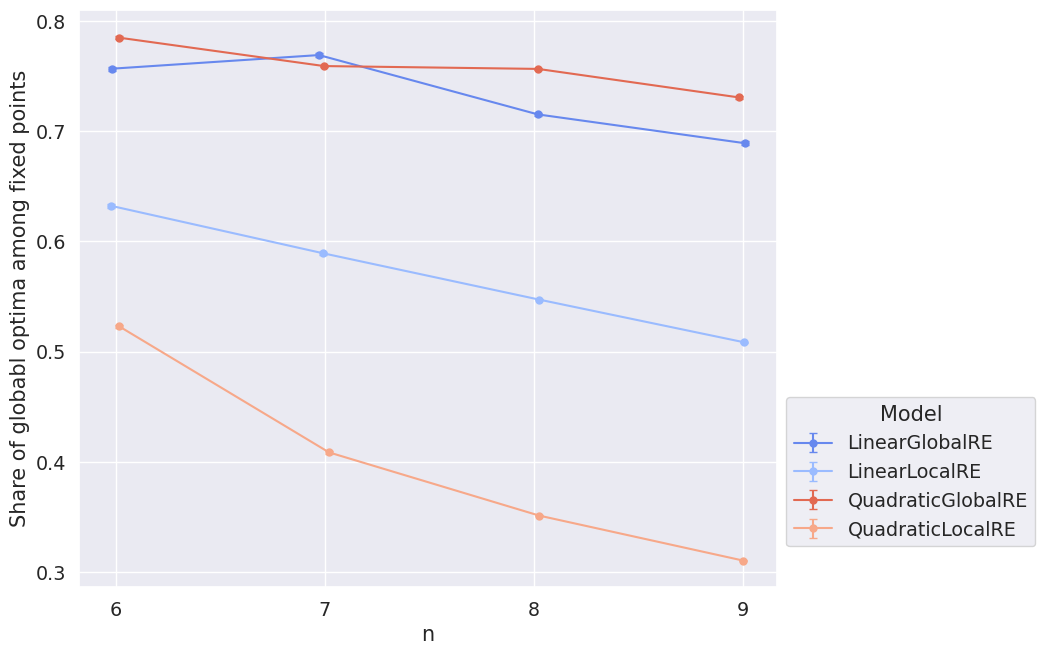

In [10]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_pp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_std = 'std_fpgo_fp_pp',
                         file_name='rel-fpgo-fp-by-n-pp', output_dir=figures_output_dir)

In [12]:
result_df_restricted = rel_share_of_property(re_data.loc[re_data['weight_account'] < re_data['weight_systematicity']], 
                                             property_col= 'fixed_point_is_global_optimum',
                                             groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                             collapse_branches=False,
                                             col_rename=col_rename, 
                                             bootstrap=bootstrap, n_resamples=n_resamples)

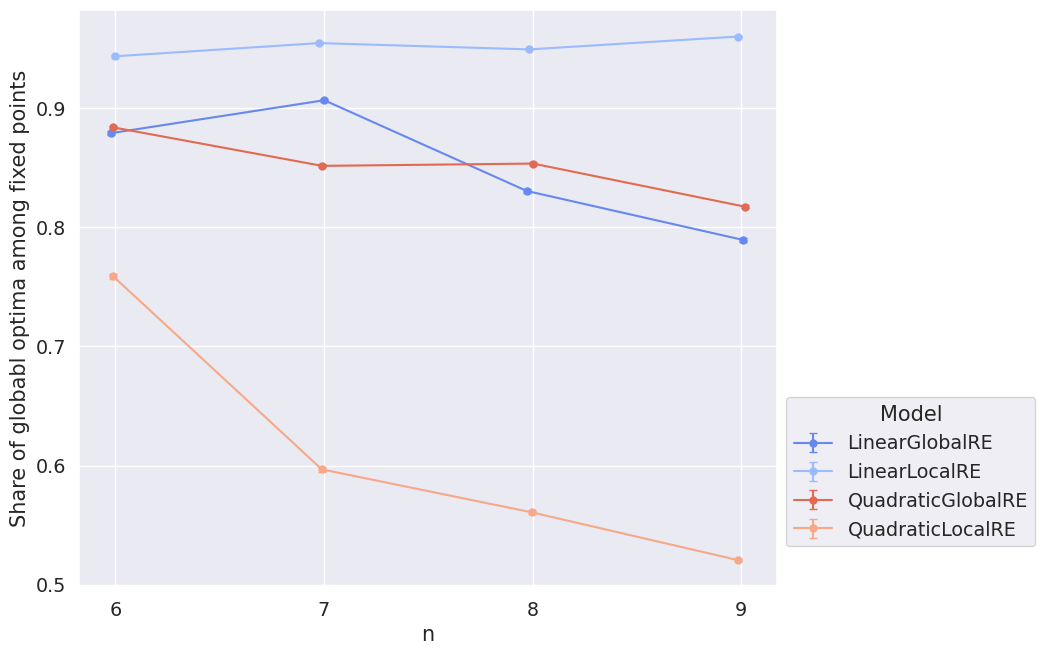

In [13]:
plot_multiple_error_bars(data=result_df_restricted.reset_index(), 
                         var_y='rel_fpgo_fp_pp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_std = 'std_fpgo_fp_pp',
                         file_name='rel-fpgo-fp-by-n-pp-restricted', output_dir=figures_output_dir)

### Dependence on mean number of premises

In [80]:
### Calculating global optima among fixed points (process perspective) (`pp` = process perspective)
col_rename = {'mean':'rel_fpgo_fp_pp', 'std': 'std_fpgo_fp_pp', 'size':'n_branches', 'sum':'n_fpgo_pp'}

result_df = rel_share_of_property(re_data, 
                                  property_col= 'fixed_point_is_global_optimum',
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  collapse_branches=False,
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)

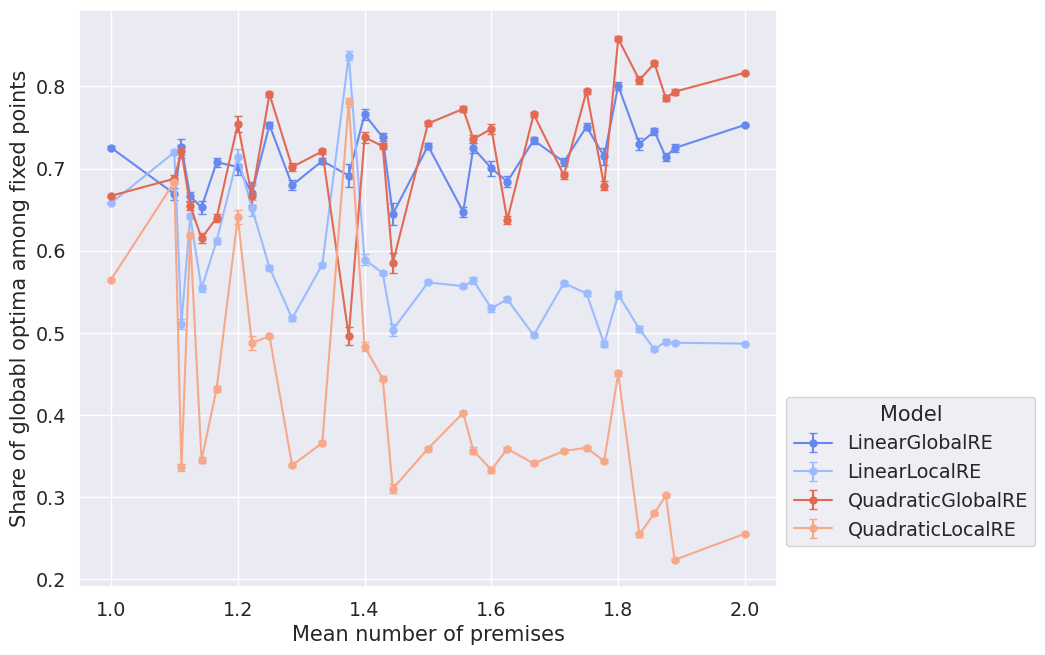

In [81]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_fp_pp', 
                         ylabel='Share of globabl optima among fixed points',
                         var_x = 'mean_n_premises', xlabel = 'Mean number of premises', xticks=None,
                         var_std = 'std_fpgo_fp_pp',
                         jitter=False,
                         file_name='rel-fpgo-fp-by-np-pp', output_dir=figures_output_dir)

### Dependence on $\alpha$-weights

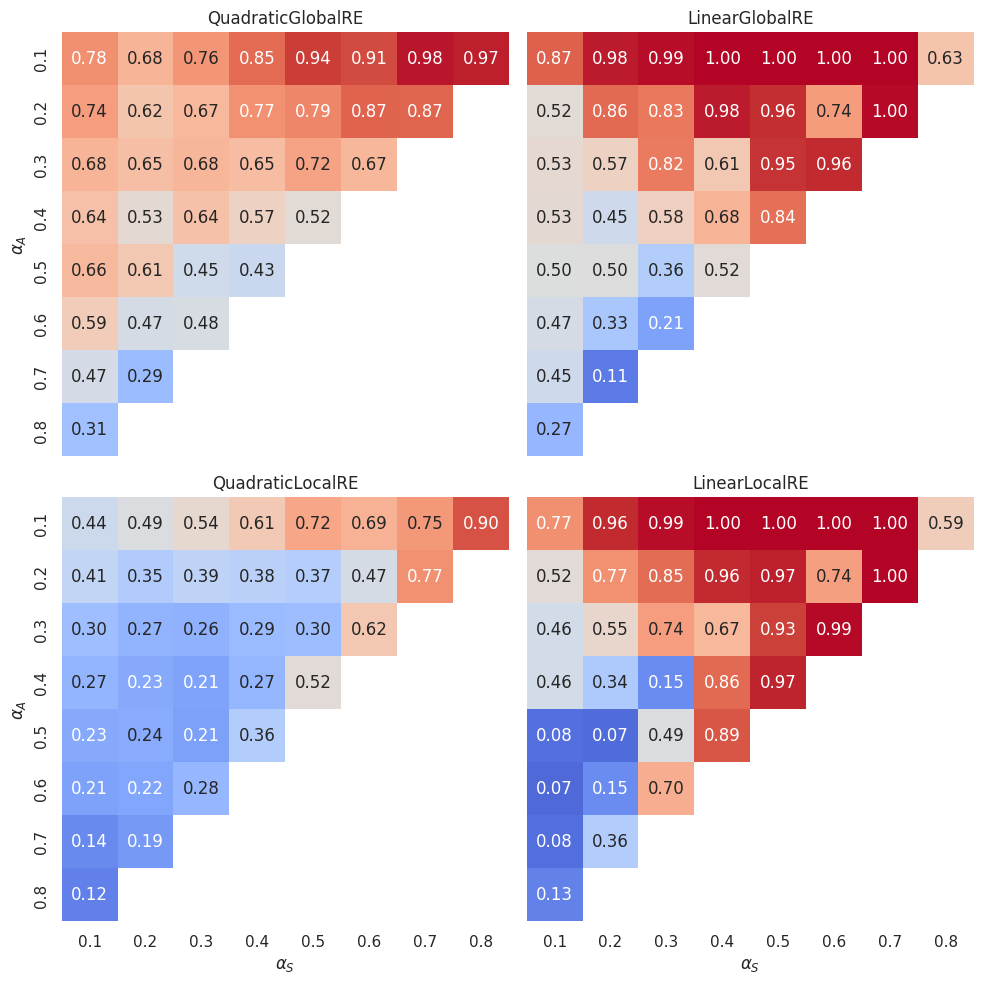

In [82]:
heat_maps_by_weights(re_data = re_data, values = 'fixed_point_is_global_optimum', 
                     #title = 'Share of global optima among fixed points (process perspective)', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', 
                     vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-fp-pp', output_dir=figures_output_dir,
                     bootstrap=False)
    

#### Local vs. Global (go among fp)

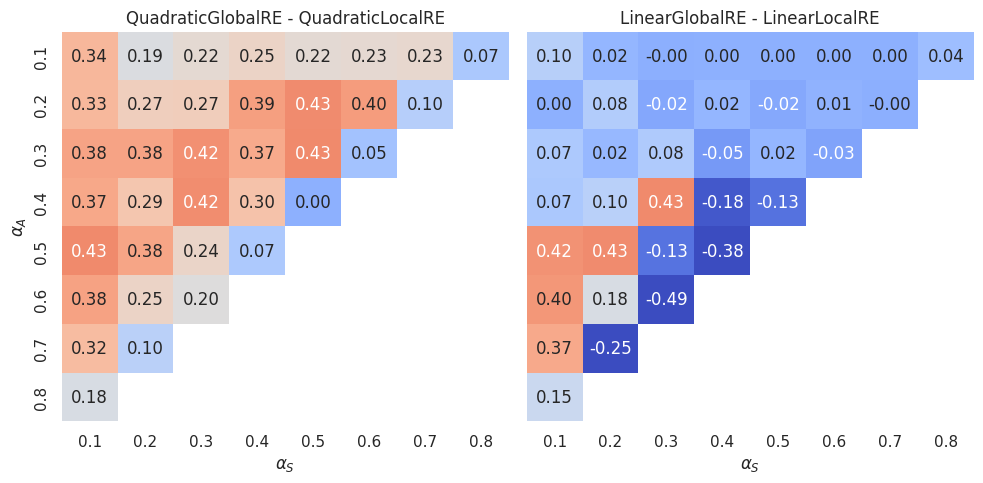

In [83]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = re_data, 
                          values = 'fixed_point_is_global_optimum',
                          #title = 'Share of global optima among fixed points (process perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-fp-pp', output_dir=figures_output_dir,
                          bootstrap=False)


### Dependence on $\alpha$-weights and mean number of premises

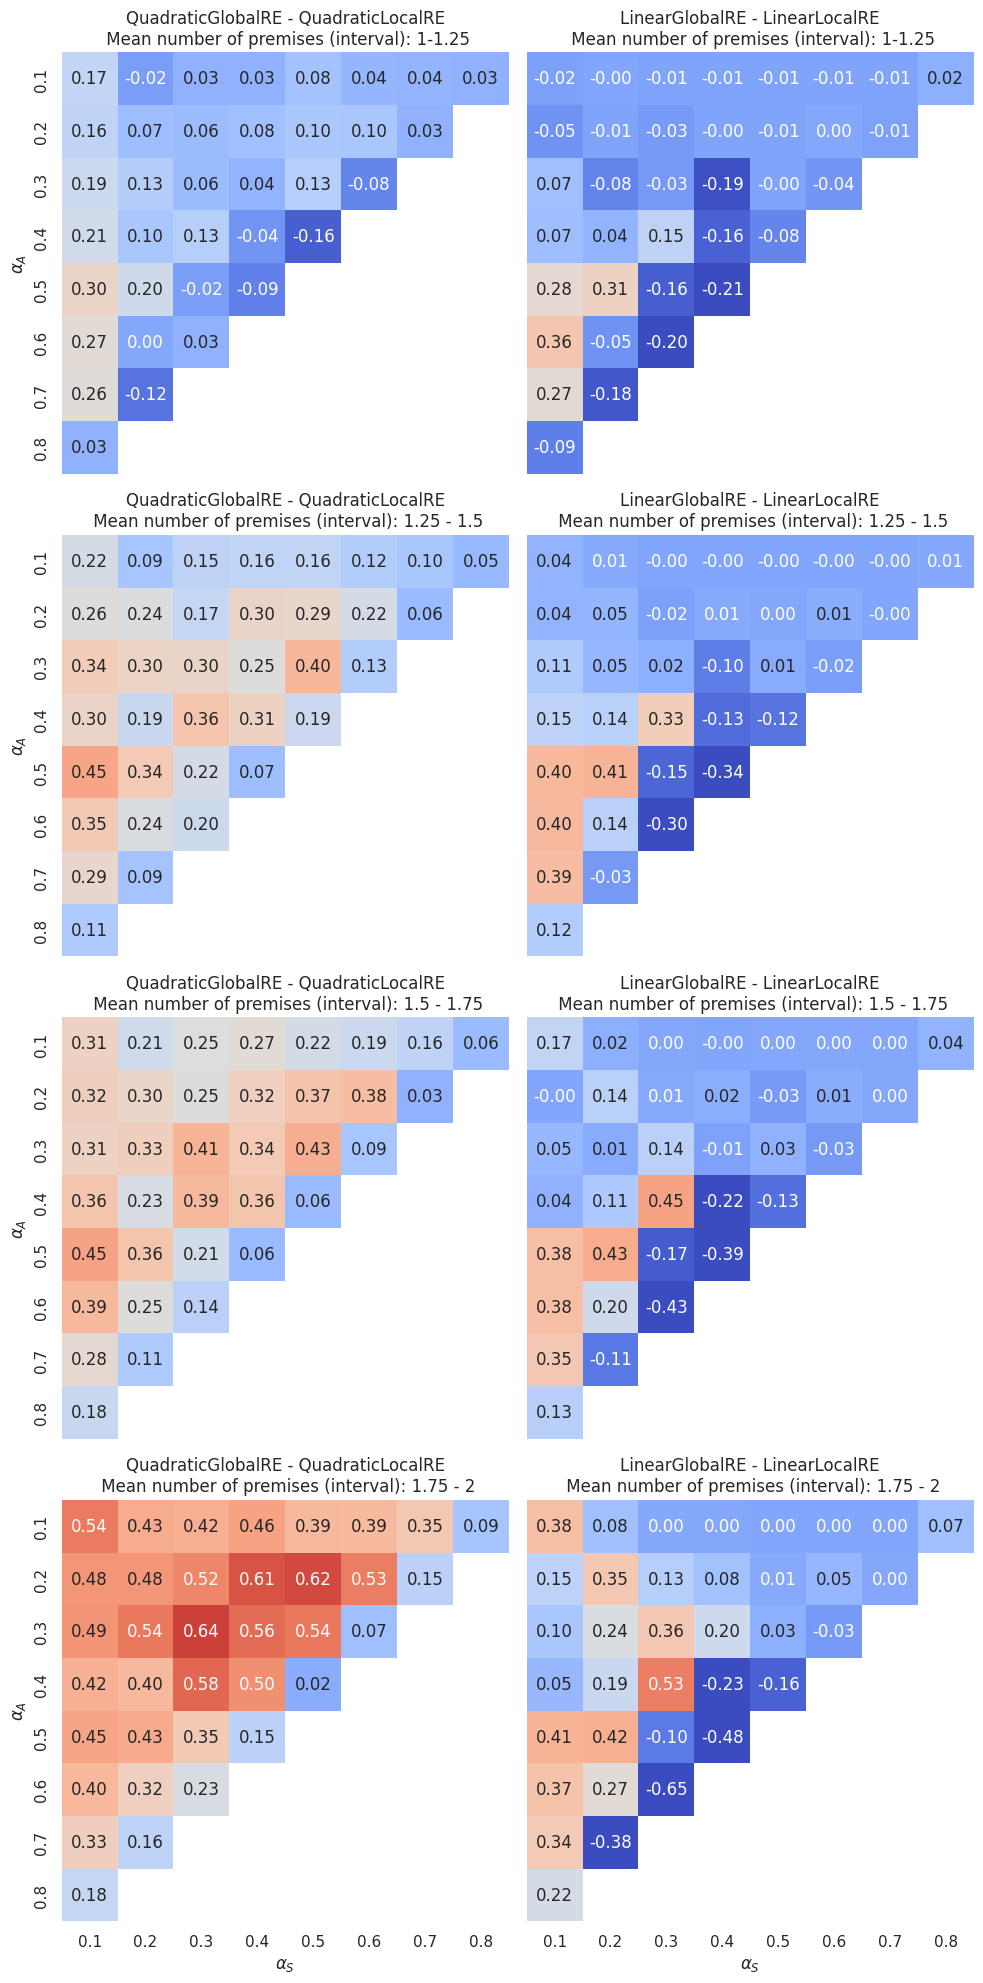

In [84]:
diff_heat_maps_by_weights(re_data = re_data, 
                          values = 'fixed_point_is_global_optimum',
                          row='mean_n_premises_bin',
                          row_title='Mean number of premises (interval)',
                          #title = 'Share of global optima among fixed points (process perspective)', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.7,
                          file_name='diff-hm-rel-fpgo-fp-by-n-premises-pp', output_dir=figures_output_dir,
                          bootstrap=False)


## GO-Reachability: FP among GO

### Dependence on sentence pool

In [85]:
### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df = rel_share_of_property(re_data, 
                                  property_col='go_fixed_point',
                                  collapse_branches=True,
                                  groupby_cols=['model_short_name', 'model_name', 'n_sentence_pool'], 
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)


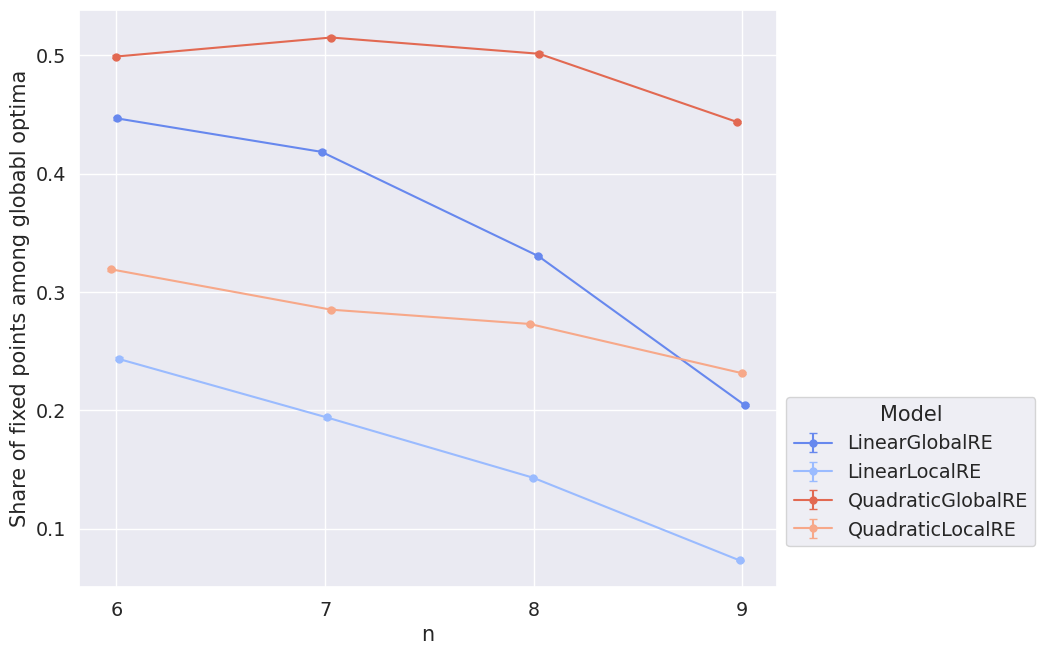

In [86]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_go', 
                         ylabel='Share of fixed points among globabl optima',
                         var_std = 'std_fpgo_go',
                         file_name='rel-fpgo-go-by-n', output_dir=figures_output_dir)

### Dependence on mean number of premises

In [87]:
### GO-Reachability: Calculating fixed points among global optima 
col_rename = {'mean':'rel_fpgo_go', 'std': 'std_fpgo_go', 'size':'n_global_optima'}

result_df = rel_share_of_property(re_data, 
                                  property_col='go_fixed_point',
                                  collapse_branches=True,
                                  groupby_cols=['model_short_name', 'model_name', 'mean_n_premises'], 
                                  col_rename=col_rename, 
                                  bootstrap=bootstrap, n_resamples=n_resamples)


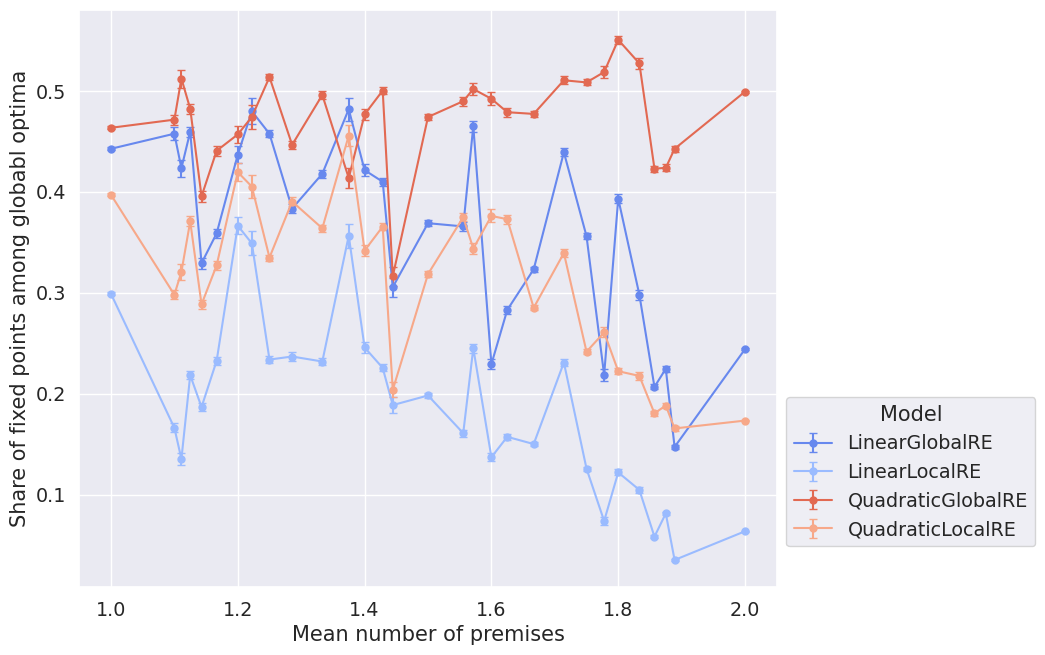

In [88]:
plot_multiple_error_bars(data=result_df.reset_index(), 
                         var_y='rel_fpgo_go', 
                         ylabel='Share of fixed points among globabl optima',
                         var_x='mean_n_premises', xlabel='Mean number of premises', xticks=None,
                         var_std = 'std_fpgo_go',
                         jitter=False,
                         file_name='rel-fpgo-go-by-np', output_dir=figures_output_dir)

### Dependence on $\alpha$-weights

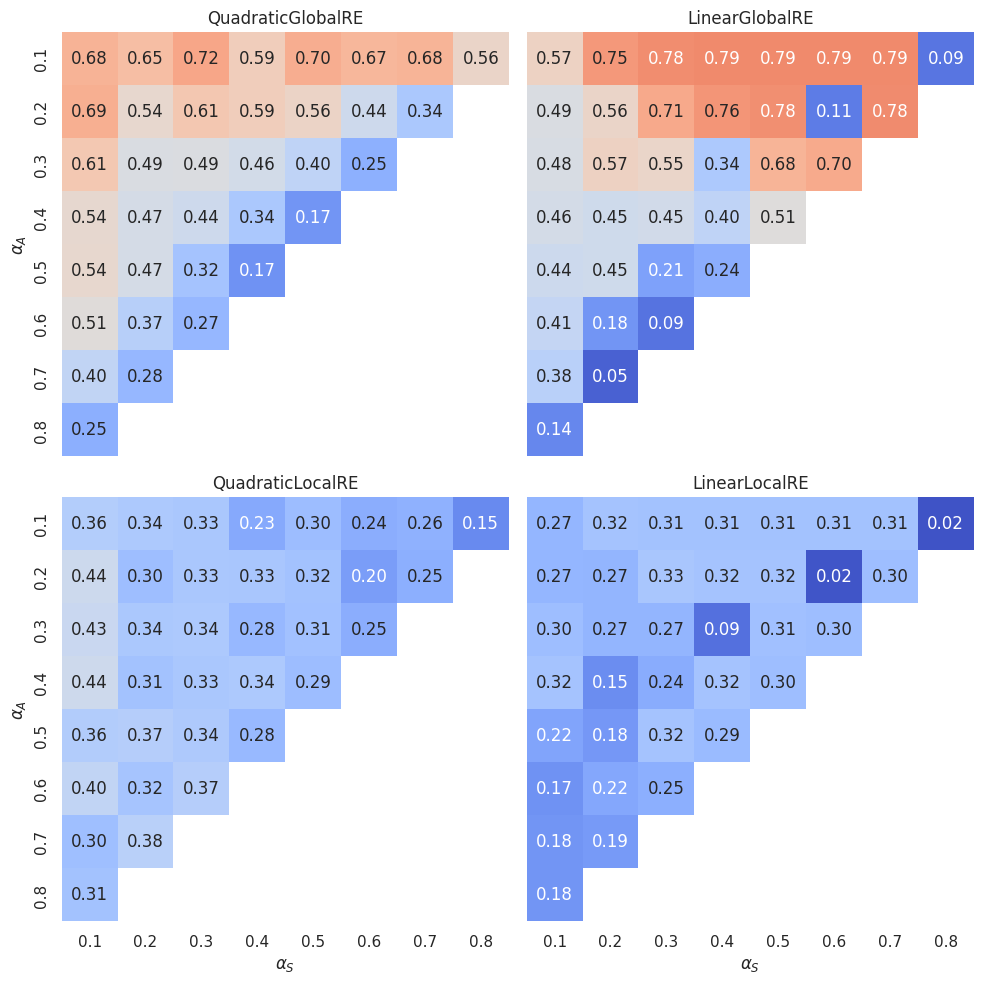

In [89]:
heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                     values = 'go_fixed_point', 
                     #title = 'Share of fixed points among global optima', 
                     annot_fmt="{:2.2f}\n",
                     annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=0, vmax=1,
                     file_name='hm-rel-fpgo-go', output_dir=figures_output_dir,
                     bootstrap=False)
    

#### Local vs. Global (go among fp)

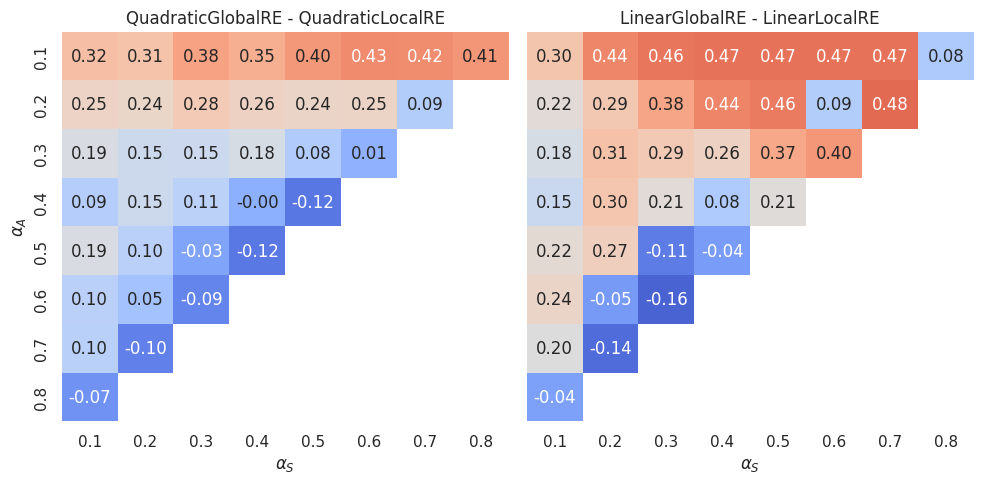

In [90]:
comparisons_by_model_name = [('LinearLocalRE', 'LinearGlobalRE'), ('QuadraticLocalRE', 'QuadraticGlobalRE')]

diff_heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                          values = 'go_fixed_point',
                          #title = 'Share of fixed points among global optima', 
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-go', output_dir=figures_output_dir,
                          bootstrap=False)


### Dependence on $\alpha$-weights and mean number of premises

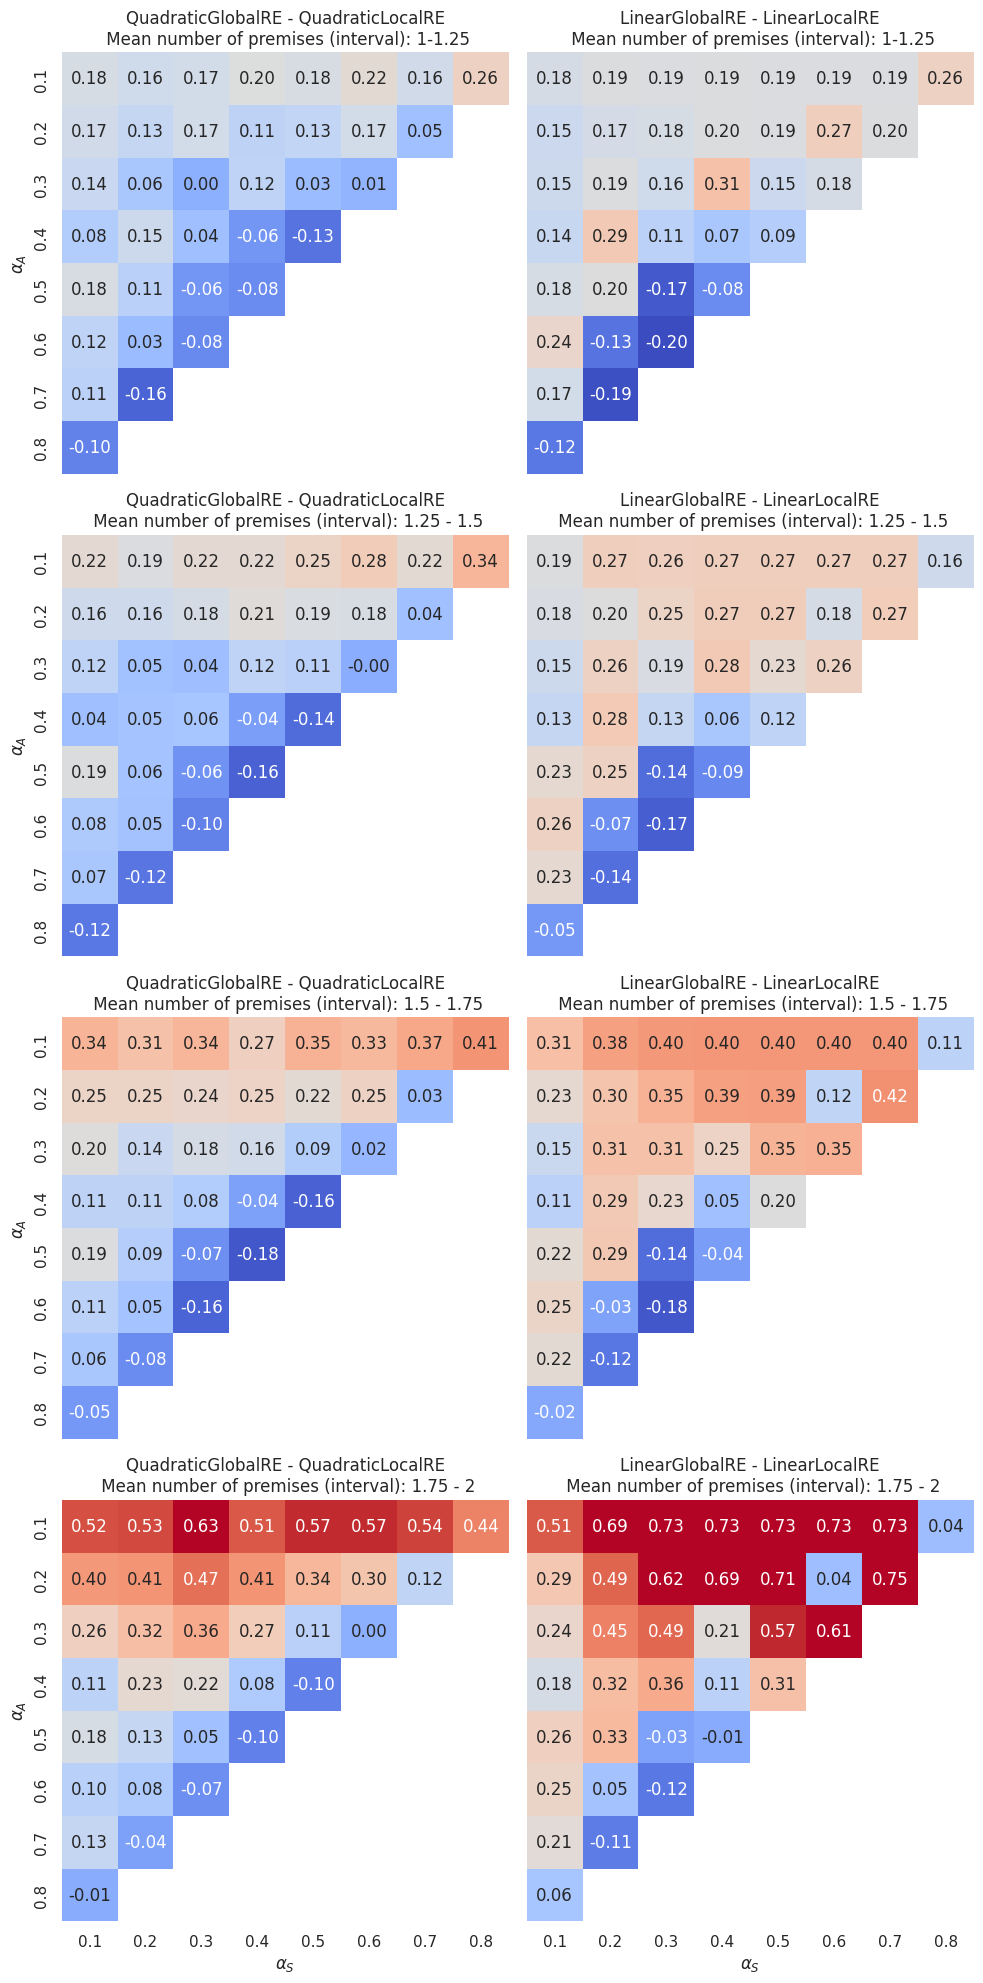

In [91]:
diff_heat_maps_by_weights(re_data = data_collapsed_go_exploded, 
                          values = 'go_fixed_point',
                          #title = 'Share of fixed points among global optima', 
                          row='mean_n_premises_bin',
                          row_title='Mean number of premises (interval)',
                          comparisons_by_model_name=comparisons_by_model_name,
                          annot_fmt="{:2.2f}",
                          annot_std = False, annot_std_fmt = r'$\pm${:2.2f}', vmin=-.2, vmax=0.6,
                          file_name='diff-hm-rel-fpgo-go-by-n-premises', output_dir=figures_output_dir,
                          bootstrap=False)
